In [ ]:
import sys
import os
threads_n='8'
os.environ["OMP_NUM_THREADS"] = threads_n # export OMP_NUM_THREADS=4
os.environ["OPENBLAS_NUM_THREADS"] = threads_n # export OPENBLAS_NUM_THREADS=4
os.environ["MKL_NUM_THREADS"] = threads_n # export MKL_NUM_THREADS=6

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import pickle

import importlib
import monti
import montiutils

import matplotlib as mpl
import matplotlib.pyplot as plt

# set project parameters
cancer_type='COAD'
bdir='../dataset'
pdir='../dataset/%s'%(cancer_type)
odir='./tutorial_COAD'

In [181]:
# load mRNA data
gene_gl=pd.read_csv('%s/data/omics_gene_mat.txt'%(pdir), header=0, index_col=0)
gene_gl.to_csv('%s/gene_gc.txt'%(odir))

# converting methylation data to gene-level
methylation_gl=monti.make_methylation_gcentric('%s/data/omics_methylation_mat.txt'%(pdir), '%s/data/omics_gene_mat.txt'%(pdir))
methylation_gl.to_csv('%s/methylation_gc.txt'%(odir))

# converting miRNA data to gene-level
mirna_gl=monti.make_mir_gcentric('%s/data/omics_mirna_mat.txt'%(pdir), '%s/data/omics_gene_mat.txt'%(pdir))
mirna_gl.to_csv('%s/mirna_gc.txt'%(odir))

gene_gl=pd.read_csv('%s/gene_gc.txt'%(odir), header=0, index_col=0, sep=',')
methylation_gl=pd.read_csv('%s/methylation_gc.txt'%(odir), header=0, index_col=0, sep=',')
mirna_gl=pd.read_csv('%s/mirna_gc.txt'%(odir), header=0, index_col=0, sep=',')

reading methylation data...
reading TSS promoter probe annotation...
converting methylation to gene level data...
reading mirna file...
reading mirna gene target file...
converting miRNAs to gene level data...


In [236]:
# create an multi-omics data object including all omics data
modata={'gene':gene_gl, 'methylation':methylation_gl, 'mirna':mirna_gl}

# load clinical features
label_data=pd.read_csv('%s/data/subtypes.txt'%(pdir), header=0)

# load list of genes to use for the analysis
genelist=pd.read_csv('%s/annotation/genelist.txt'%(bdir), header=0)

In [291]:
# create environment for saving results
cv_n=10 # n cross validation
montiutils.make_env(odir, cv_n)

# split data into train and test data sets for cross validation
cv_data=montiutils.split_data(modata, label_data, genelist, odir, cv_n)

generating cross validation data set 0...
generating cross validation data set 1...
generating cross validation data set 2...
generating cross validation data set 3...
generating cross validation data set 4...
generating cross validation data set 5...
generating cross validation data set 6...
generating cross validation data set 7...
generating cross validation data set 8...
generating cross validation data set 9...


In [317]:
# set parameters
rank=80
maxiter=50
tol_val=10e-6

# perform n cross validation
for i in range(cv_n):
	print('cv: ', i)
	# O, G, P=monti.decompose_tensor(np.asarray(tdat), rank, maxiter, tol_val)
	tres=monti.decompose_tensor(cv_data[cvidx].train_data, rank, maxiter, tol_val)
	np.save('%s/cvs/cv_%d/out/components/r%d_td.npy'%(odir, cvidx, rank), tres)
	O, G, P=tres
	sample_info=monti.get_sample_info(modata.keys(), cv_data[cvidx].train_labels, genelist)
	alpha=0.01
	feature_samples, feature_labels=monti.select_features(P, alpha, sample_info, odir, cvidx)
	feature_genes, gene_labels=monti.get_featuregenes(G, cv_data[cvidx], sample_info, odir, cvidx, rank)
	predres=monti.measure_accuracy(cv_data[cvidx], feature_genes, sample_info, odir, cvidx)
	
	# store results to cross validation data sets
	cv_data[i].sample_info=sample_info
	cv_data[i].feature_samples=feature_samples
	cv_data[i].feature_labels=feature_labels
	cv_data[i].feature_genes=feature_genes
	cv_data[i].gene_labels=gene_labels
	cv_data[i].predres=predres



cv:  0

Selected features:	21
Selected genes:	6045
  - CMS1: 1270 genes
  - CMS2: 3062 genes
  - CMS3: 2001 genes
  - CMS4: 2222 genes
cv:  1

Selected features:	29
Selected genes:	5395
  - CMS1: 1671 genes
  - CMS2: 2360 genes
  - CMS3: 2112 genes
  - CMS4: 1318 genes
cv:  2

Selected features:	23
Selected genes:	5209
  - CMS1: 1353 genes
  - CMS2: 1841 genes
  - CMS3: 2394 genes
  - CMS4: 1315 genes
cv:  3

Selected features:	26
Selected genes:	5931
  - CMS1: 1452 genes
  - CMS2: 3715 genes
  - CMS3: 1548 genes
  - CMS4: 3537 genes
cv:  4

Selected features:	26
Selected genes:	3880
  - CMS1: 701 genes
  - CMS2: 1970 genes
  - CMS3: 2124 genes
  - CMS4: 1934 genes
cv:  5

Selected features:	22
Selected genes:	3844
  - CMS1: 1926 genes
  - CMS2: 2780 genes
  - CMS3: 631 genes
  - CMS4: 2165 genes
cv:  6

Selected features:	22
Selected genes:	6697
  - CMS1: 2120 genes
  - CMS2: 1135 genes
  - CMS3: 2293 genes
  - CMS4: 2197 genes
cv:  7

Selected features:	20
Selected genes:	2141
  - CM

In [323]:
# let's observe the results of cross validation data set #0 (cv0)
cvidx=0
print(cv_data[cvidx].predres)

              precision    recall  f1-score   support

        CMS1       1.00      1.00      1.00         1
        CMS2       0.88      1.00      0.93        14
        CMS3       1.00      0.67      0.80         3
        CMS4       1.00      0.92      0.96        13

    accuracy                           0.94        31
   macro avg       0.97      0.90      0.92        31
weighted avg       0.94      0.94      0.93        31



In [332]:
# load the decomposition result of cv0
O, G, P=np.load('%s/cvs/cv_%d/out/components/r%d_td.npy'%(odir, cvidx, rank), allow_pickle=True)

print('O:', O.shape)
print('P:', P.shape)
print('G:', G.shape)

O: (3, 80)
P: (287, 80)
G: (14513, 80)


In [333]:
# the test labels
cv_data[cvidx].test_labels

,Sampid,Class
0,TCGA-AD-6895,CMS1
1,TCGA-AF-3911,CMS2
2,TCGA-AZ-6608,CMS2
3,TCGA-AZ-6608,CMS2
4,TCGA-CK-5912,CMS2
5,TCGA-CK-5914,CMS2
6,TCGA-CL-5918,CMS2
7,TCGA-CM-6161,CMS2
8,TCGA-D5-5537,CMS2
9,TCGA-DC-4749,CMS2


In [338]:
# the selected features and associated groups from Cp
# here, we can see that feature #6 is associated both with CMS2 and CMS4
cv_data[cvidx].feature_labels

,FeatureIndex,Group
0,35,CMS1
1,38,CMS1
2,42,CMS1
3,43,CMS1
4,53,CMS1
5,64,CMS1
6,6,CMS2
7,8,CMS2
8,15,CMS2
9,33,CMS2


In [344]:
cv_data[cvidx].gene_labels

,ENSGID,GeneSymbol,FeatureIndex,Group
0,ENSG00000000419,DPM1,0,CMS1
1,ENSG00000003249,DBNDD1,16,CMS1
2,ENSG00000004776,HSPB6,32,CMS1
3,ENSG00000004866,ST7,34,CMS1
4,ENSG00000004897,CDC27,35,CMS1
...,...,...,...,...
8550,ENSG00000277075,HIST1H2AE,14474,CMS4
8551,ENSG00000277084,RNU2-4P,14475,CMS4
8552,ENSG00000277492,SNORD3E,14486,CMS4
8553,ENSG00000278206,AL031320.2,14491,CMS4


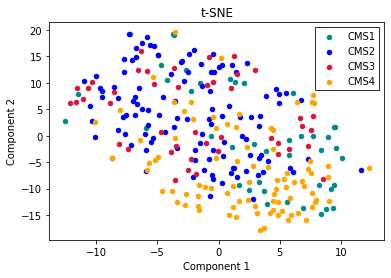

In [348]:
p=montiutils.plot_sample_features(P, cv_data[cvidx].feature_labels, cv_data[cvidx].train_labels, cv_data[cvidx].sample_info)
p.show()


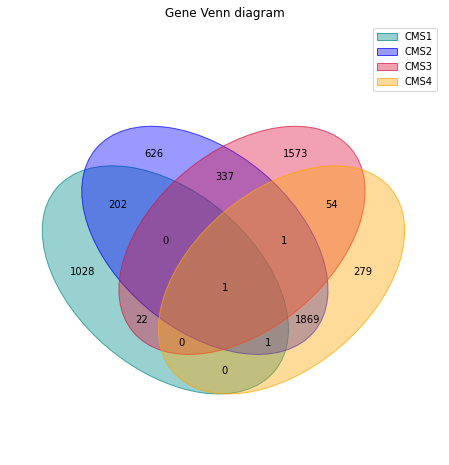

In [350]:
# plot venn diagrm of genes
p=montiutils.plot_venn(cv_data[cvidx].gene_labels, cv_data[cvidx].sample_info)
plt.show()

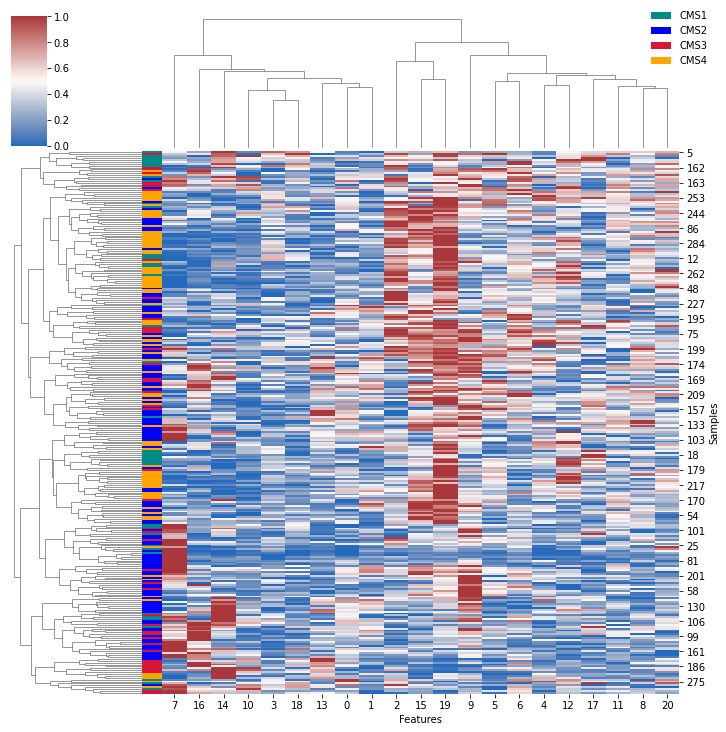

In [351]:
# plot sample heatmap (P component)
p=montiutils.plot_sample_hmap(P, cv_data[cvidx].feature_samples, cv_data[cvidx].sample_info)
p.show()

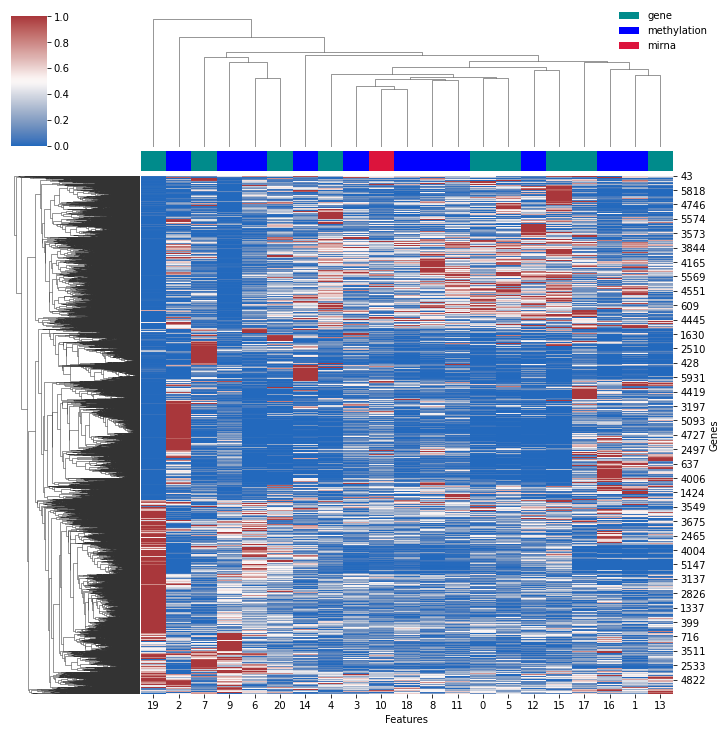

In [352]:
# plot gene heatmap (G component)
p=montiutils.plot_gene_hmap(G, O, cv_data[cvidx].feature_samples, cv_data[cvidx].feature_genes, cv_data[cvidx].sample_info)
p.show()

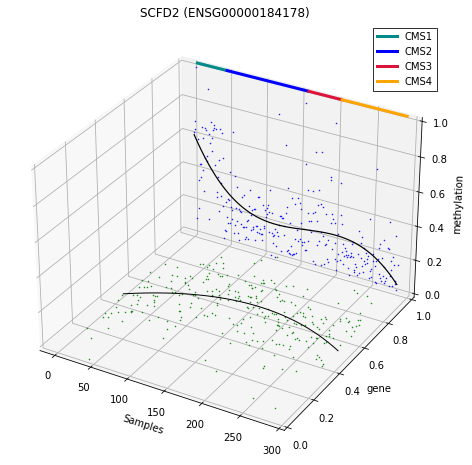

In [358]:
gidx=feature_genes[4]
montiutils.plot_gene(modata, cv_data[cvidx], gidx, cv_data[cvidx].sample_info)